In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import numpy as np
from bs4 import BeautifulSoup
import re
import string
import torch
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from PIL import Image
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    log_loss,
    matthews_corrcoef,
    balanced_accuracy_score,
    cohen_kappa_score
)


%matplotlib inline

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
df=pd.read_csv("/kaggle/input/email-spam-ham-prediction/sms_spam.csv")

In [4]:
wordcloud_mask=np.array(Image.open("/kaggle/input/wordcloud-mask-collection/stormtrooper_mask.png"))

In [5]:
df.head()

,type,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5574 entries, 0 to 5573
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   type    5574 non-null   object
 1   text    5574 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [7]:
df.shape

(5574, 2)

In [8]:
df.isnull().sum()

type    0
text    0
dtype: int64

In [9]:
df.rename(columns={'type': "label"},inplace=True)

In [10]:
df.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


# Compare Label

In [11]:
df["label"].value_counts()

label
ham     4827
spam     747
Name: count, dtype: int64

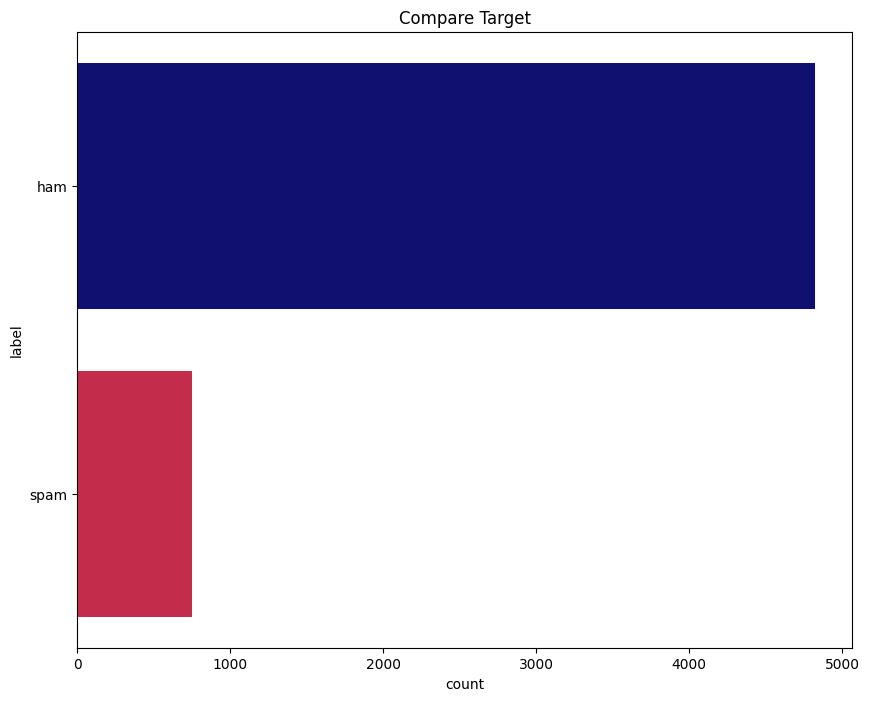

In [12]:
plt.figure(figsize=(10,8))
sns.countplot(data=df, y="label",palette=["navy","crimson"])
plt.title("Compare Target")
plt.show()

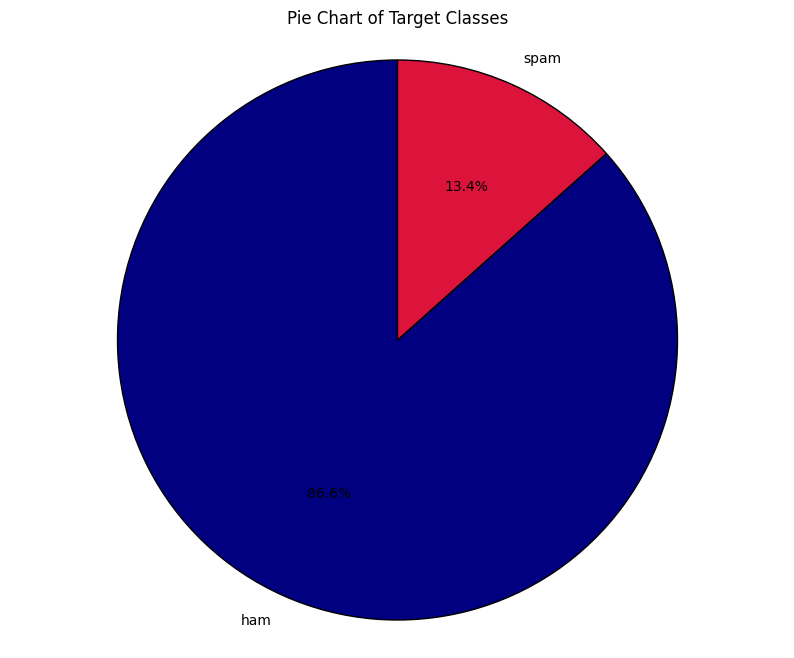

In [13]:
label_counts = df['label'].value_counts()

plt.figure(figsize=(10, 8))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', colors=["navy", "crimson"], startangle=90, wedgeprops={'edgecolor': 'black'})
plt.title("Pie Chart of Target Classes")
plt.axis("equal")
plt.show()

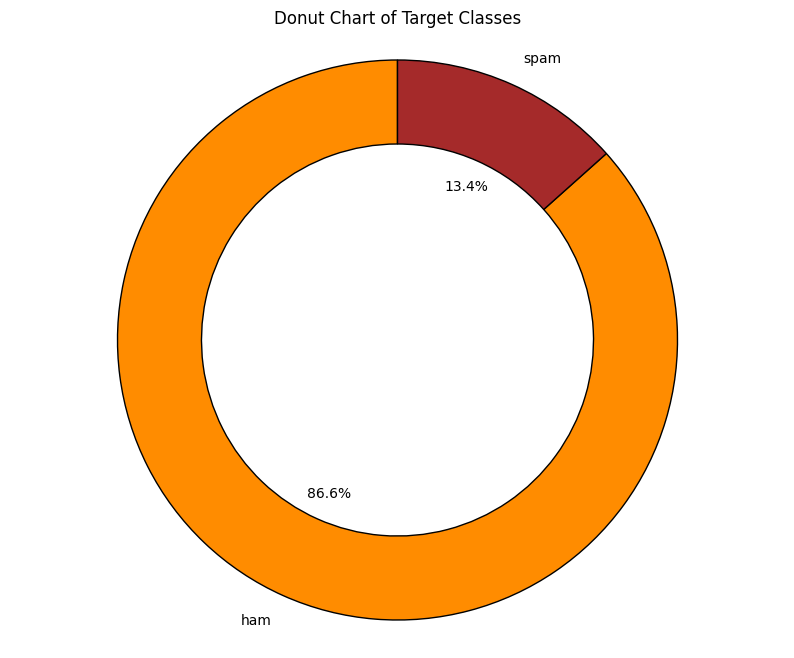

In [14]:
plt.figure(figsize=(10, 8))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', colors=["darkorange", "brown"], startangle=90, wedgeprops={'edgecolor': 'black', 'width': 0.3})
plt.axis("equal")
plt.title("Donut Chart of Target Classes")
plt.show()

# Count Character

In [15]:
df["character_count"]=df["text"].str.len()

# Count Word

In [16]:
df['word_count'] = df['text'].str.split().str.len()

# Count Sentence

In [17]:
df['sentence_count'] = df['text'].apply(lambda x: len(nltk.sent_tokenize(x)))

In [18]:
df["label"].replace({"ham":0,"spam":1},inplace=True)

In [19]:
df.head()

,label,text,character_count,word_count,sentence_count
0,0,"Go until jurong point, crazy.. Available only ...",111,20,2
1,0,Ok lar... Joking wif u oni...,29,6,2
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,28,2
3,0,U dun say so early hor... U c already then say...,49,11,1
4,0,"Nah I don't think he goes to usf, he lives aro...",61,13,1


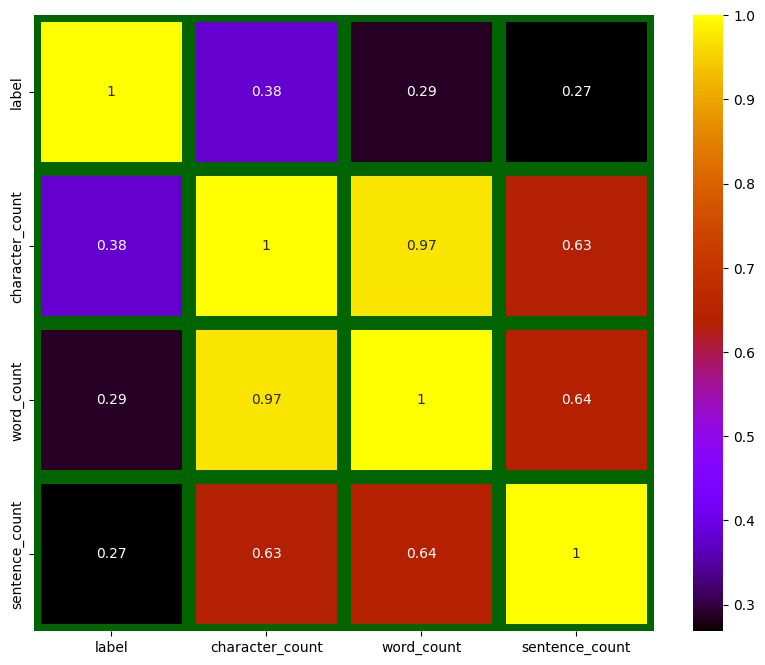

In [20]:
cor=df[["label","character_count","word_count","sentence_count"]].corr()
plt.figure(figsize=(10,8))
sns.heatmap(cor,annot=True,cmap="gnuplot",linewidths=10, linecolor='darkgreen')
plt.show()

# Ham Data Length

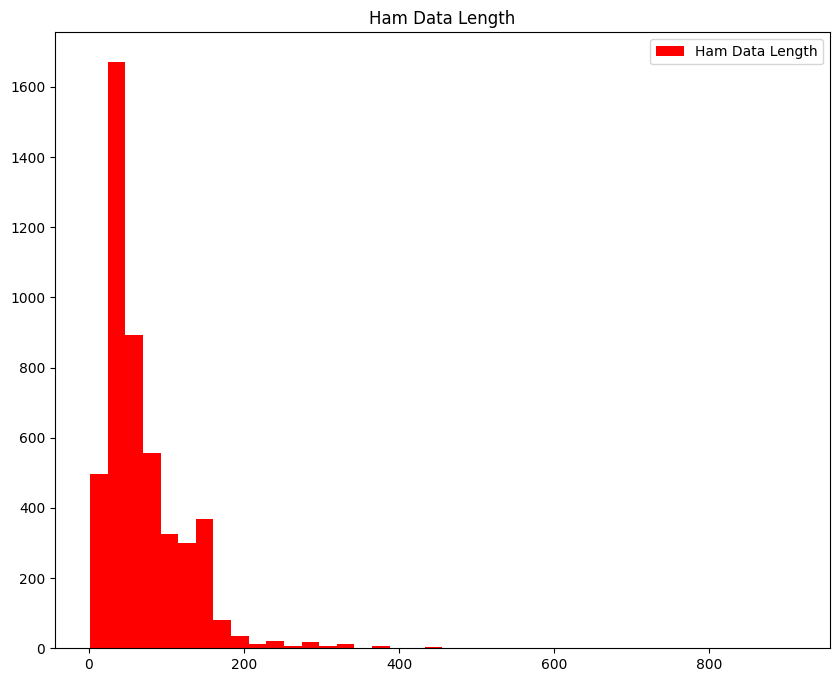

In [21]:
plt.figure(figsize=(10,8))
ham_len=df[df["label"]==0]["text"].str.len()
plt.hist(ham_len, bins=40,label='Ham Data Length',color="red")
plt.title("Ham Data Length")
plt.legend()
plt.show()


# Spam Data Length

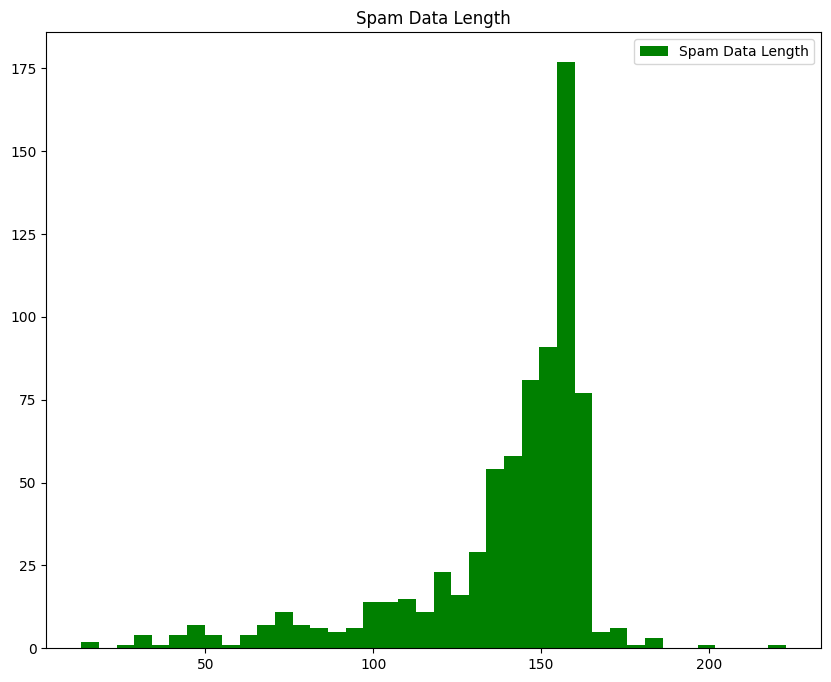

In [22]:
plt.figure(figsize=(10,8))
spam_len=df[df["label"]==1]["text"].str.len()
plt.hist(spam_len, bins=40,label='Spam Data Length',color="green")
plt.title("Spam Data Length")
plt.legend()
plt.show()

# Compare Ham & Spam

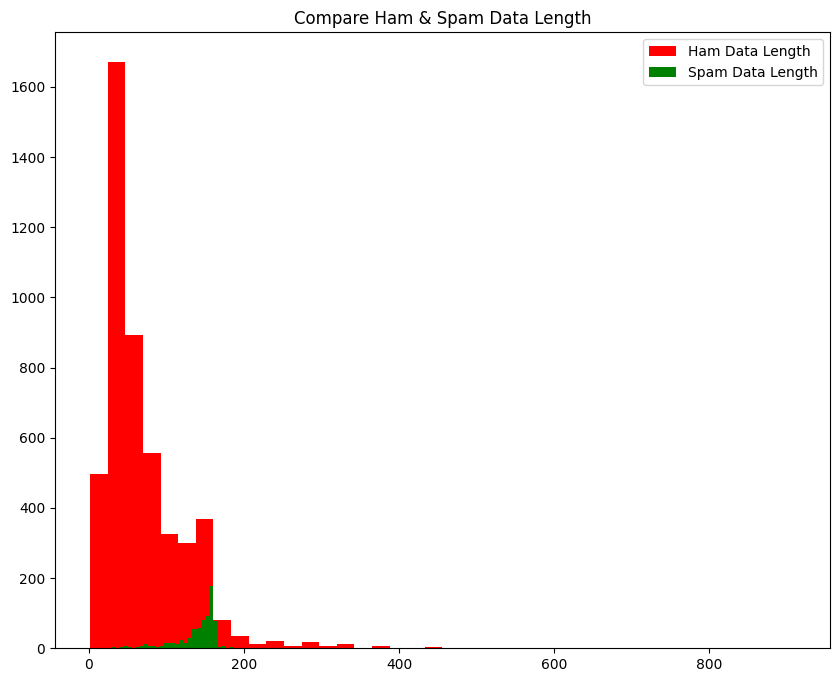

In [23]:
plt.figure(figsize=(10,8))

plt.hist(ham_len, bins=40,label='Ham Data Length',color="red")
plt.hist(spam_len, bins=40,label='Spam Data Length',color="green")
plt.title("Compare Ham & Spam Data Length")
plt.legend()
plt.show()

In [24]:
df["text"][0]

'Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...'

# Clean Data

In [25]:
def clean_text(text):
    if isinstance(text, str):
        text = BeautifulSoup(text, 'html.parser').get_text()
        text = re.sub(r"[^a-zA-Z]", " ", text)
        text = text.translate(str.maketrans("", "", string.punctuation))

        emoji_pattern = re.compile("[" 
                                   u"\U0001F600-\U0001F64F" 
                                   u"\U0001F300-\U0001F5FF"  
                                   u"\U0001F680-\U0001F6FF"  
                                   u"\U0001F1E0-\U0001F1FF"  
                                   u"\U00002702-\U000027B0"
                                   u"\U000024C2-\U0001F251"
                                   "]+", flags=re.UNICODE)
        text = emoji_pattern.sub(r'', text)

        text = re.sub(r"#.*", "", text)
        text = re.sub(r"/\*.*?\*/", "", text, flags=re.DOTALL)
        text = text.lower()

        stop_words = set(stopwords.words('english'))
        tokens = word_tokenize(text)
        tokens = [word for word in tokens if word not in stop_words]

        text = ' '.join(tokens)

        return text
    else:
        return ""


In [26]:
df["text"]=df["text"].apply(clean_text)

<ipython-input-25-3c2a92c5052f>:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()


In [27]:
df["text"][0]

'go jurong point crazy available bugis n great world la e buffet cine got amore wat'

# ALL Data Wordcloud

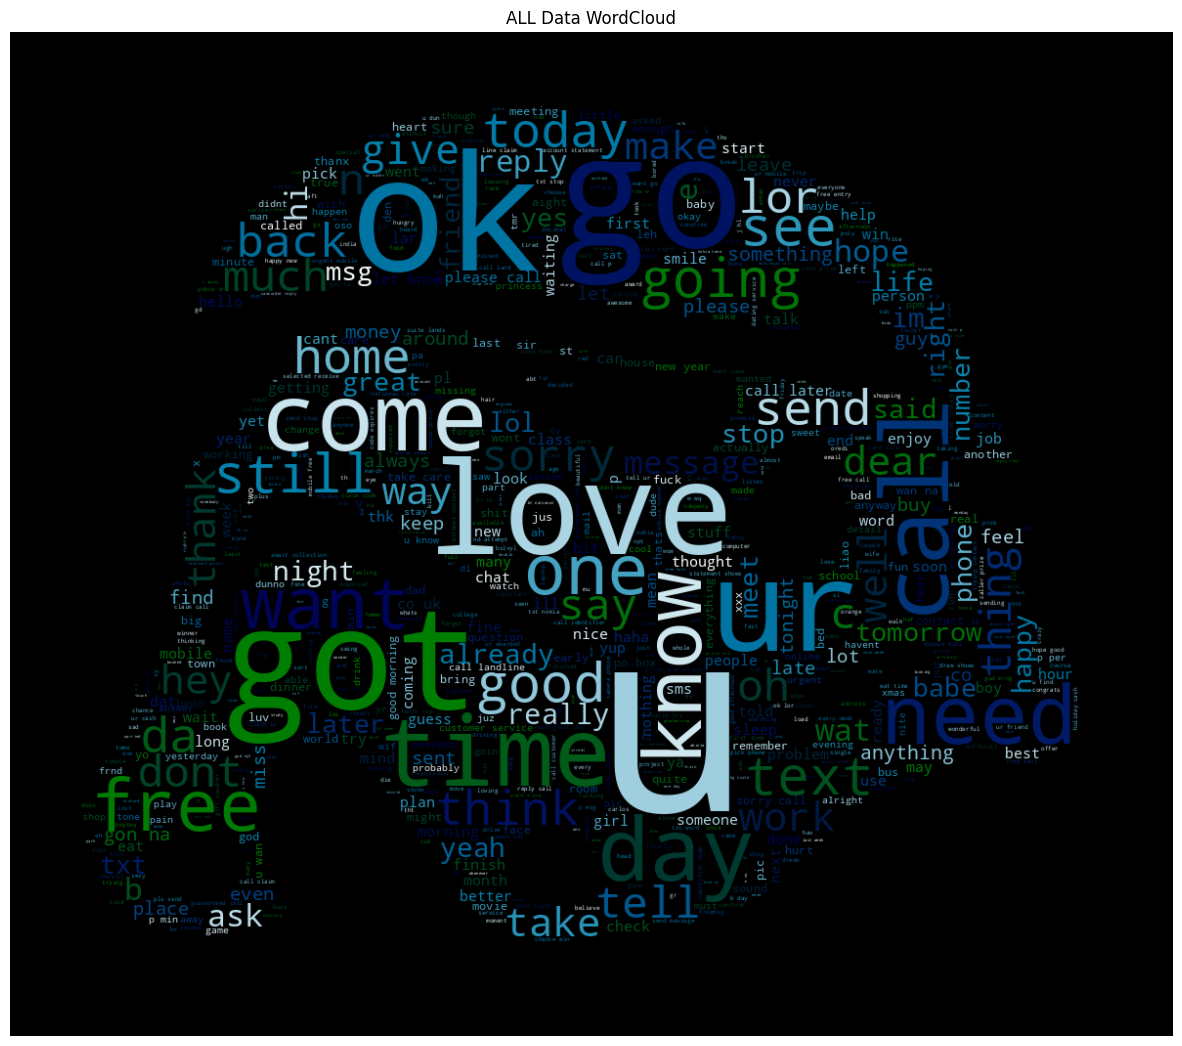

In [28]:
from wordcloud import WordCloud, STOPWORDS
plt.figure(figsize=(15,15))
all_text=" ".join(df['text'].values.tolist())
wordcloud = WordCloud(width=800, height=800,stopwords=STOPWORDS, background_color='black', max_words=800,colormap="ocean",mask=wordcloud_mask).generate(all_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("ALL Data WordCloud")
plt.show()

# Ham Data Wordcloud

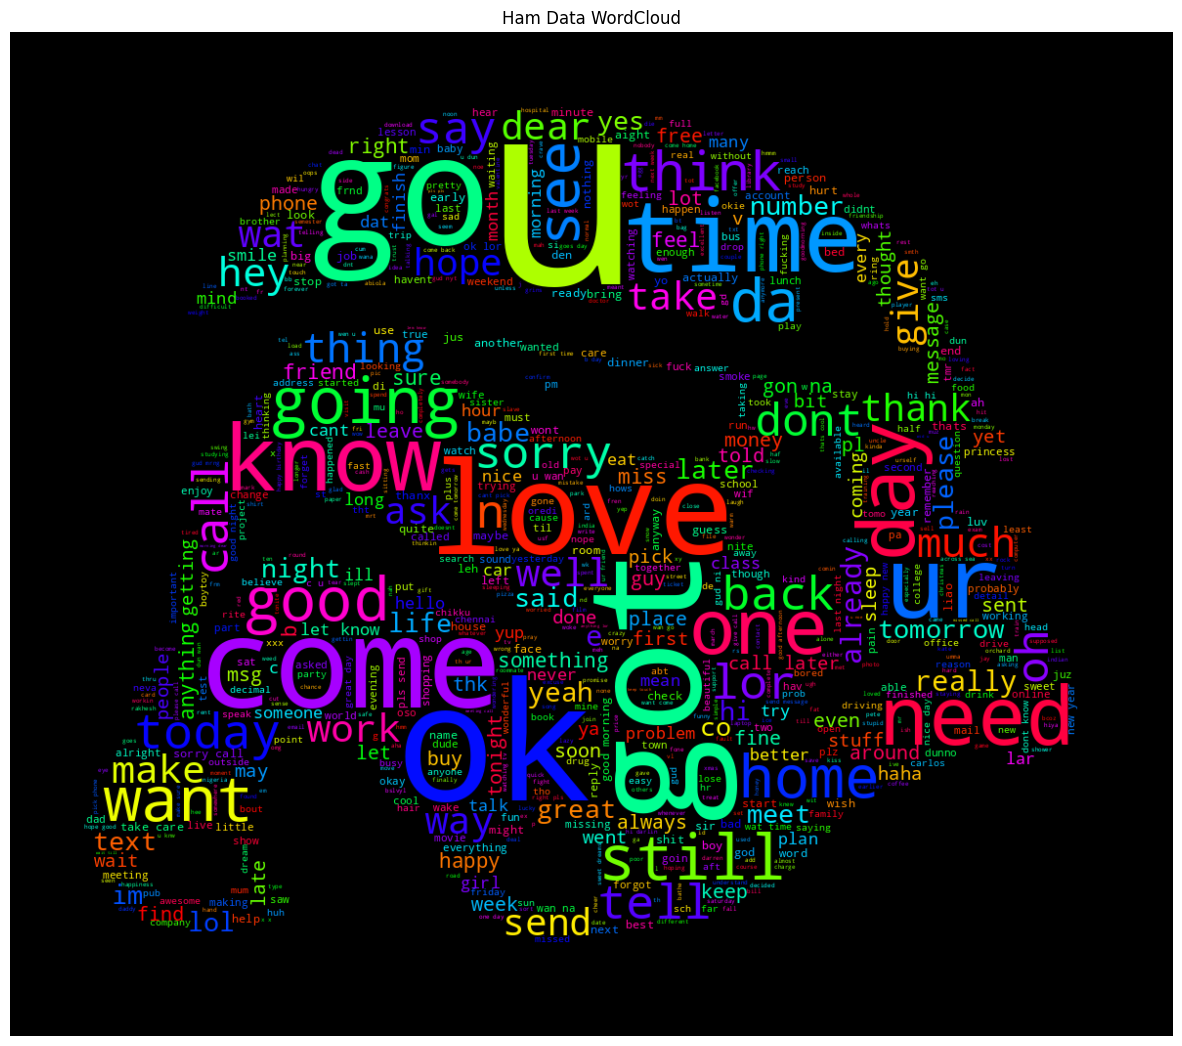

In [29]:
plt.figure(figsize=(15,15))
ham_wordcloud=df[df["label"]==0]
ham_text=" ".join(ham_wordcloud['text'].values.tolist())
wordcloud = WordCloud(width=800, height=800,stopwords=STOPWORDS, background_color='black', max_words=800,colormap="hsv",mask=wordcloud_mask).generate(ham_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Ham Data WordCloud")
plt.axis('off')
plt.show()

# Spam Data WordCloud

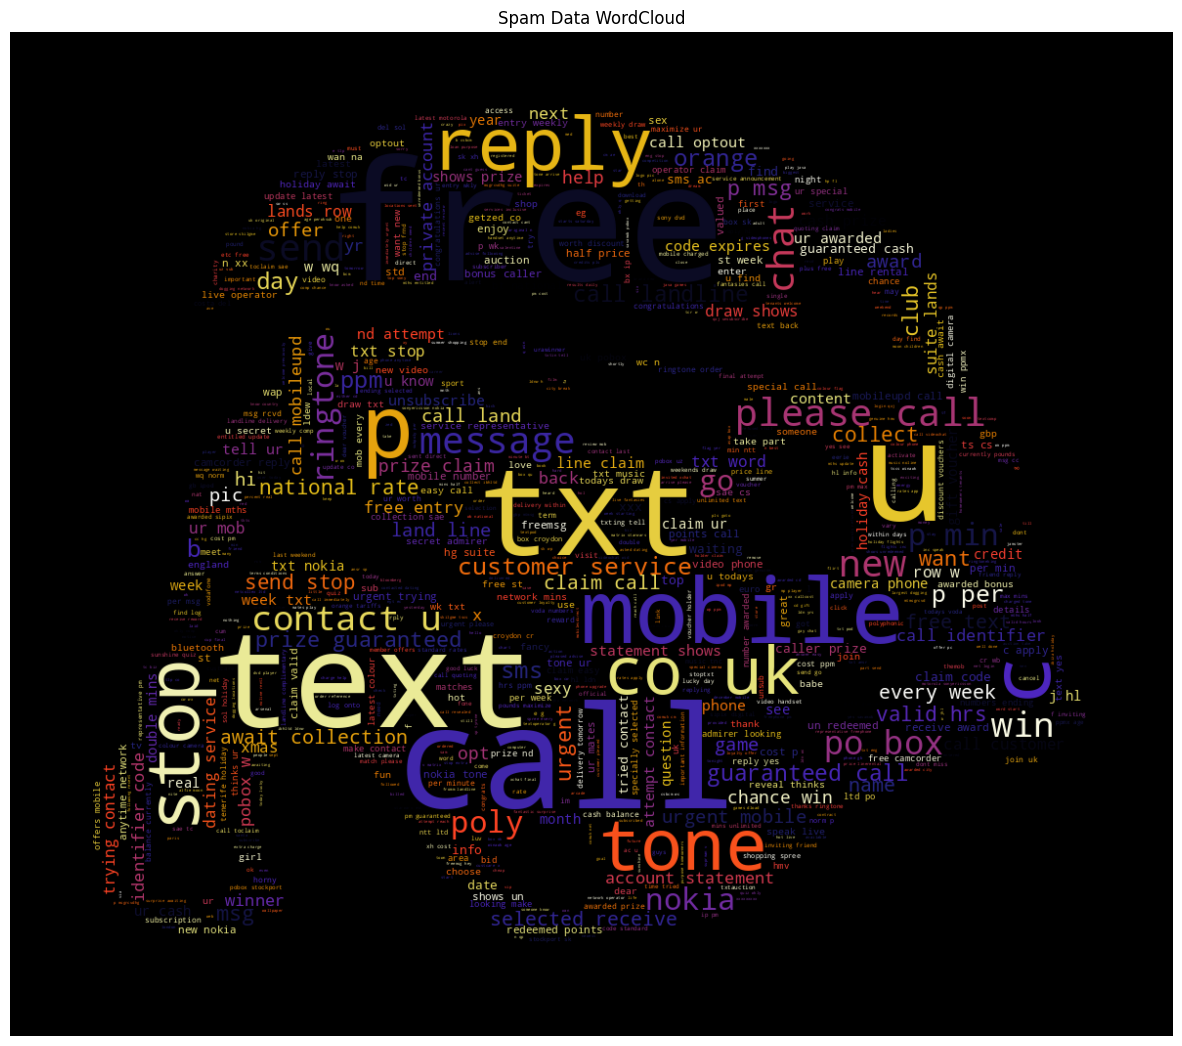

In [30]:
plt.figure(figsize=(15,15))
spam_wordcloud=df[df["label"]==1]
spam_text=" ".join(spam_wordcloud['text'].values.tolist())
wordcloud = WordCloud(width=800, height=800,stopwords=STOPWORDS, background_color='black', max_words=800,colormap="CMRmap",mask=wordcloud_mask).generate(spam_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Spam Data WordCloud")
plt.axis('off')
plt.show()

# 30 Most common Words From All Text

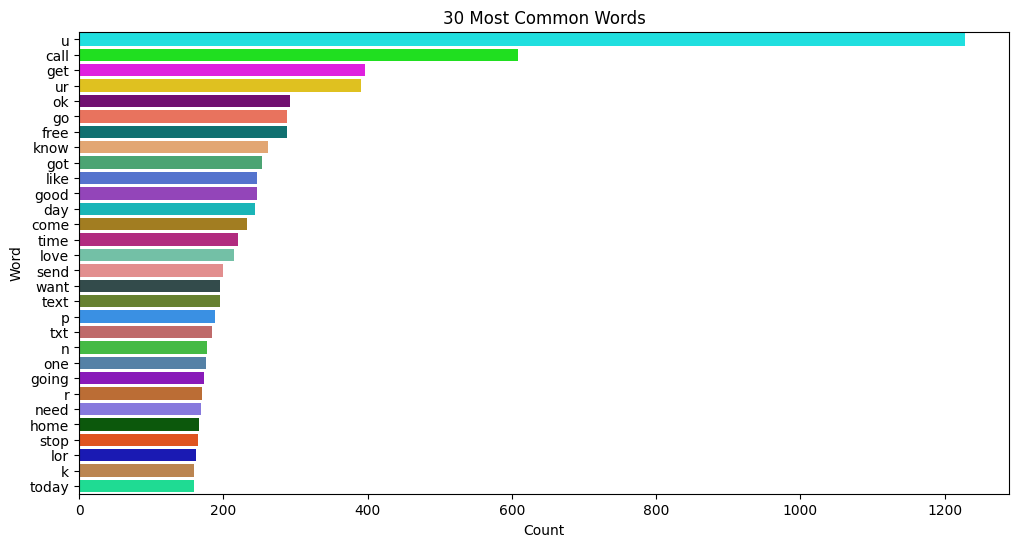

In [31]:
from itertools import chain
from collections import Counter

data_set =df["text"].str.split()
all_words = list(chain.from_iterable(data_set))
counter = Counter(all_words)
common_words = counter.most_common(30)
df_common_words = pd.DataFrame(common_words, columns=['Word', 'Count'])

colors = ["cyan", "lime", "magenta", "gold", "purple", "tomato", "teal", "sandybrown", "mediumseagreen",
          "royalblue", "darkorchid", "darkturquoise", "darkgoldenrod", "mediumvioletred", "mediumaquamarine",
          "lightcoral", "darkslategray", "olivedrab", "dodgerblue", "indianred", "limegreen", "steelblue",
          "darkviolet", "chocolate", "mediumslateblue", "darkgreen", "orangered", "mediumblue", "peru", "mediumspringgreen"]

plt.figure(figsize=(12, 6))
sns.barplot(x='Count', y='Word', data=df_common_words, palette=colors)
plt.title('30 Most Common Words')
plt.xlabel('Count')
plt.ylabel('Word')
plt.show()

# Most Common Words From Ham Text

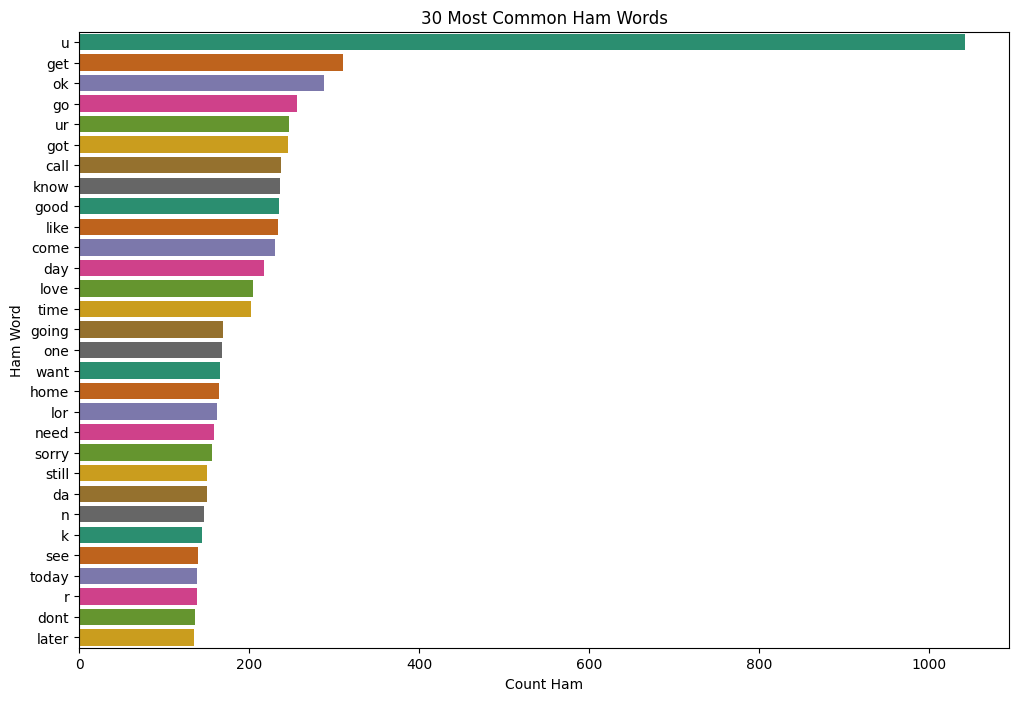

In [32]:

ham_text = df[df["label"] == 0]
data_set = ham_text["text"].str.split()
all_words = [word for sublist in data_set for word in sublist]

counter = Counter(all_words)
common_words = counter.most_common(30)
df_common_words = pd.DataFrame(common_words, columns=['Word', 'Count'])

plt.figure(figsize=(12, 8))
sns.barplot(x='Count', y='Word', data=df_common_words, palette=sns.color_palette("Dark2", n_colors=len(df_common_words)))
plt.title('30 Most Common Ham Words')
plt.xlabel('Count Ham')
plt.ylabel('Ham Word')
plt.show()


# Most Common Words From Spam Text

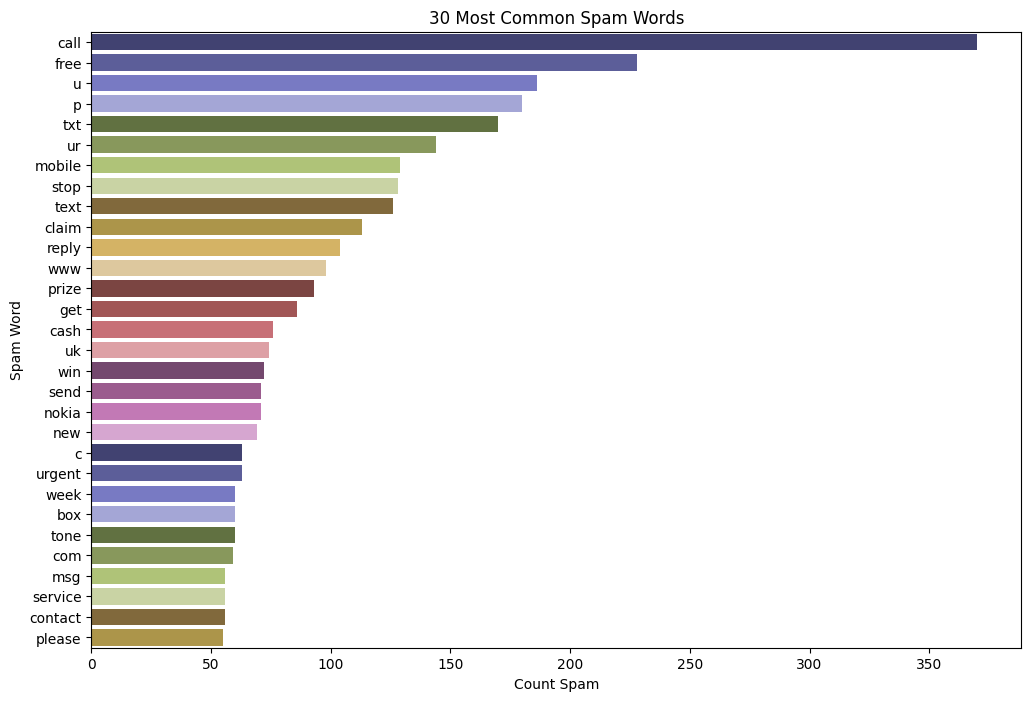

In [33]:
spam_text = df[df["label"] == 1]
data_set = spam_text["text"].str.split()
all_words = [word for sublist in data_set for word in sublist]

counter = Counter(all_words)
common_words = counter.most_common(30)
df_common_words = pd.DataFrame(common_words, columns=['Word', 'Count'])

plt.figure(figsize=(12, 8))
sns.barplot(x='Count', y='Word', data=df_common_words, palette=sns.color_palette("tab20b", n_colors=len(df_common_words)))
plt.title('30 Most Common Spam Words')
plt.xlabel('Count Spam')
plt.ylabel('Spam Word')
plt.show()


# Character Count

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


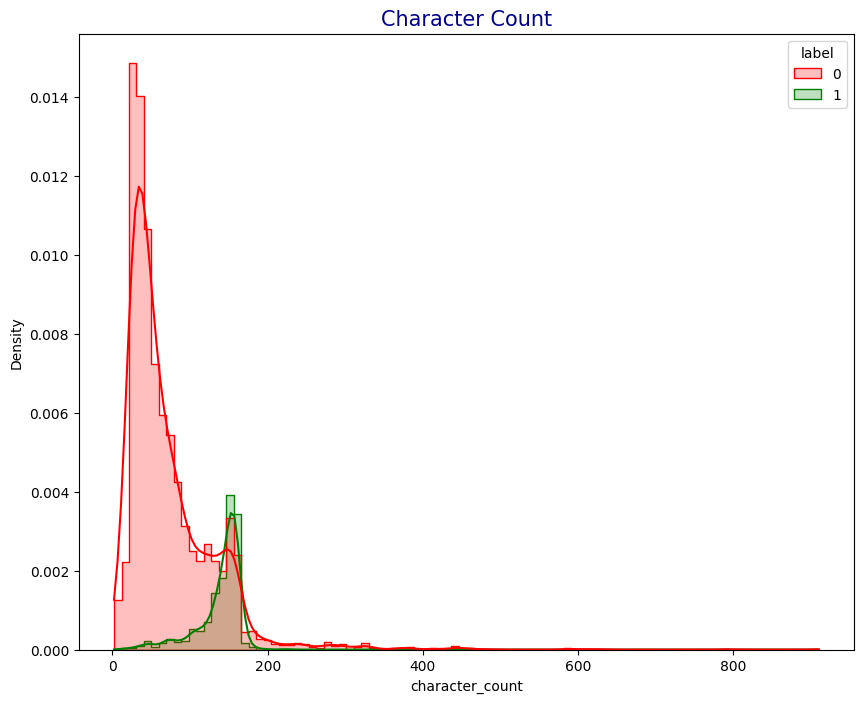

In [34]:
color=["red","green"]
plt.figure(figsize=(10,8))

sns.histplot(data=df,x="character_count",palette=color,kde=True,hue="label",element="step",stat="density")
plt.title("Character Count",fontsize=15,color="darkblue")
plt.show()

# Word Count

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


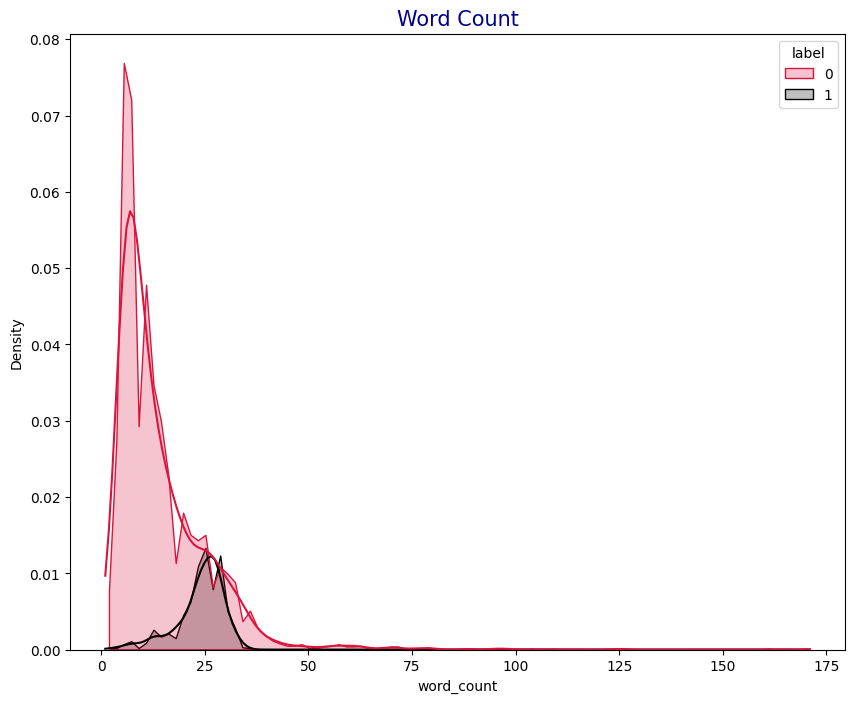

In [35]:
color=["crimson","black"]
plt.figure(figsize=(10,8))

sns.histplot(data=df,x="word_count",palette=color,kde=True,hue="label",element="poly",stat="density")
plt.title("Word Count",fontsize=15,color="darkblue")
plt.show()

# Sentence Count

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


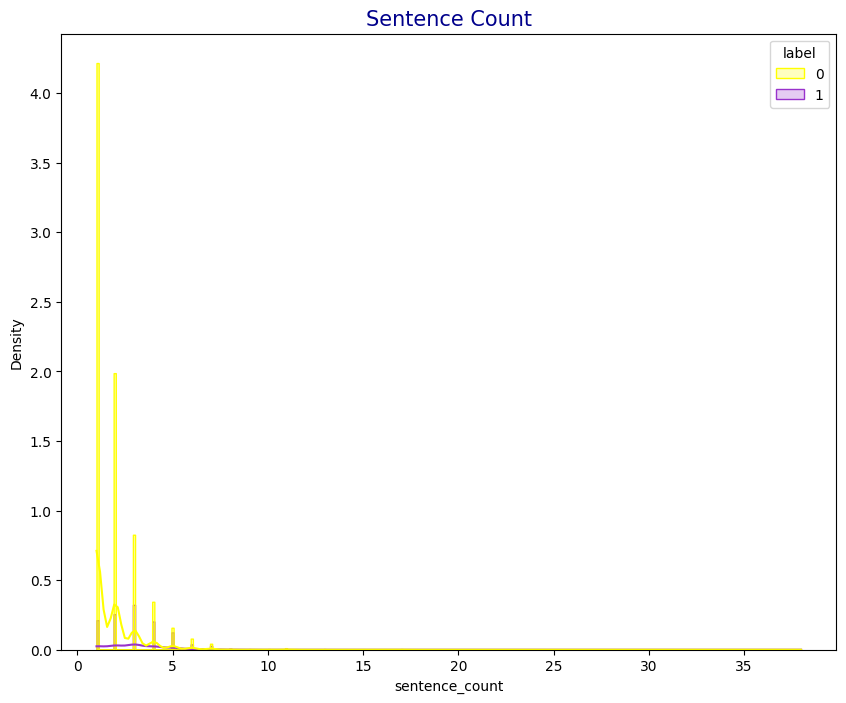

In [36]:
color=["yellow","darkorchid"]
plt.figure(figsize=(10,8))
sns.histplot(data=df,x="sentence_count",palette=color,kde=True,hue="label",element="step",stat="density")
plt.title("Sentence Count",fontsize=15,color="darkblue")
plt.show()

In [37]:
df.drop(["character_count","word_count","sentence_count"],axis=1,inplace=True)

# Average Text Length

In [38]:
avg_len=df["text"].apply(len)
avg_len=avg_len.mean()
print(f"Average Text Length is : {avg_len:.2f}")

Average Text Length is : 49.53


In [39]:
!pip install torchtext==0.6

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 2.1 MB/s eta 0:00:00


In [40]:
import torch
from torchtext import data
import spacy
import torch.nn as nn
from torchsummary import summary

# Load the SpaCy model for tokenization and initialize Fields for text and labels

In [41]:
TEXT = data.Field(tokenize="spacy", tokenizer_language="en_core_web_sm", batch_first=True, include_lengths=True)
LABEL = data.LabelField(dtype=torch.float, batch_first=True)

# Set up the fields and load the dataset for text classification (spam/ham prediction)

### Load the dataset from a CSV file, specifying the format and fields

In [42]:
fields = [("type",LABEL),('text',TEXT)]
training_data = data.TabularDataset(path="/kaggle/input/email-spam-ham-prediction/sms_spam.csv",
                                    format="csv",
                                    fields=fields,
                                    skip_header=True)

In [43]:
print(vars(training_data.examples[0]))

{'type': 'ham', 'text': ['Go', 'until', 'jurong', 'point', ',', 'crazy', '..', 'Available', 'only', 'in', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', '...', 'Cine', 'there', 'got', 'amore', 'wat', '...']}


# Split Train And Test Data

In [44]:
import random
seed=42

train_data,test_data = training_data.split(split_ratio=0.75,random_state=random.seed(seed))

# Build vocab for text and label fields from the training data

In [45]:
TEXT.build_vocab(train_data,min_freq=2)

LABEL.build_vocab(train_data)

In [46]:
print("Size of text vocab:",len(TEXT.vocab))

Size of text vocab: 4354


In [47]:
print("Size of label vocab:",len(LABEL.vocab))

Size of label vocab: 2


In [48]:
TEXT.vocab.freqs.most_common(10)

[('.', 3745),
 ('to', 1623),
 ('I', 1527),
 ('you', 1422),
 (',', 1418),
 ('?', 1078),
 ('a', 1021),
 ('!', 970),
 ('the', 903),
 ('...', 853)]

# Creating train and validation iterators for batch processing in PyTorch using BucketIterator

In [49]:
train_iterator,validation_iterator = data.BucketIterator.splits(
    (train_data,test_data),
    batch_size = 16,
    sort_key = lambda x:len(x.text),
    sort_within_batch = True,
    device = device
)

# Create LSTM Model

In [50]:


class LSTMNet(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout):
        super(LSTMNet, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        self.lstm = nn.LSTM(embedding_dim,
                            hidden_dim,
                            num_layers=n_layers,
                            bidirectional=bidirectional,
                            dropout=dropout,
                            batch_first=True
                           )
        
        self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim * 2)
        self.fc2 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.batch_norm = nn.BatchNorm1d(hidden_dim * 2)
        self.dropout = nn.Dropout(dropout)
        self.sigmoid = nn.Sigmoid()

    def forward(self, text, text_lengths):
        embedded = self.embedding(text)
        
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.cpu(), batch_first=True)
        
        packed_output, (hidden_state, cell_state) = self.lstm(packed_embedded)
        
        hidden = torch.cat((hidden_state[-2, :, :], hidden_state[-1, :, :]), dim=1)
        
        hidden = self.batch_norm(hidden)
        hidden = self.dropout(hidden)
        
        dense_output = self.fc1(hidden)
        dense_output = torch.relu(dense_output)
        
        dense_output = self.fc2(dense_output)
        dense_output = torch.relu(dense_output)
        
        dense_output = self.fc3(dense_output)
        output = self.sigmoid(dense_output)
        
        return output


In [51]:
vocab_size=len(TEXT.vocab) 
embedding_dim=100
hidden_dim=128
output_dim=1
n_layers=2
bidirectional=True
dropout=0.2

model=LSTMNet(vocab_size,embedding_dim,hidden_dim,output_dim,n_layers,bidirectional,dropout)
model

LSTMNet(
  (embedding): Embedding(4354, 100)
  (lstm): LSTM(100, 128, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (fc1): Linear(in_features=256, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (batch_norm): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (sigmoid): Sigmoid()
)

In [52]:
import torch.optim as optim
model = model.to(device)
optimizer = optim.Adam(model.parameters(),lr=1e-4)
criterion = nn.BCELoss().to(device)


# Accuracy Function

In [53]:
def calculate_accuracy(predictions, labels):
    rounded_preds = torch.round(predictions)
    correct_matches = (rounded_preds == labels).float()
    accuracy = correct_matches.sum() / len(correct_matches)
    return accuracy

# Training Function for Binary Classification

In [54]:
from tqdm import tqdm

def train_model(model, data_iterator, optim, loss_fn):
    total_loss = 0.0
    total_acc = 0.0
    model.train()
    
    
    for data_batch in tqdm(data_iterator, desc="Training", unit="batch"):
        optim.zero_grad()
        inputs, lengths = data_batch.text
        outputs = model(inputs, lengths).squeeze()
        loss = loss_fn(outputs, data_batch.type)
        loss.backward()
        accuracy = calculate_accuracy(outputs, data_batch.type)
        optim.step()
        total_loss += loss.item()
        total_acc += accuracy.item()
    
    return total_loss / len(data_iterator), total_acc / len(data_iterator)


# Validation Function for Binary Classification

In [55]:
from tqdm import tqdm

def validate(net, data_iter, loss_fn):
    total_loss = 0.0
    total_accuracy = 0.0
    
    net.eval()
    
   
    with torch.no_grad():
        for data in tqdm(data_iter, desc="Validation", unit="batch"):
            input_data, input_lengths = data.text
            preds = net(input_data, input_lengths).squeeze()
            loss = loss_fn(preds, data.type)
            acc = calculate_accuracy(preds, data.type)
            total_loss += loss.item()
            total_accuracy += acc.item()
    
    return total_loss / len(data_iter), total_accuracy / len(data_iter)


In [56]:
from tabulate import tabulate

EPOCH_NUMBER = 15

train_losses = []
train_accuracies = []
valid_losses = []
valid_accuracies = []

results = []

for epoch in range(1, EPOCH_NUMBER + 1):
    train_loss, train_acc = train_model(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = validate(model, validation_iterator, criterion)
    
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accuracies.append(valid_acc)
    
    results.append([epoch, f"{train_loss:.3f}", f"{train_acc*100:.2f}%", f"{valid_loss:.3f}", f"{valid_acc*100:.2f}%"])

# Display as a table
print(tabulate(results,headers=["Epoch", "Train Loss", "Train Acc", "Val Loss", "Val Acc"],tablefmt="fancy_grid"))


Validation: 100%|██████████| 88/88 [00:00<00:00, 519.95batch/s]

╒═════════╤══════════════╤═════════════╤════════════╤═══════════╕
│   Epoch │   Train Loss │ Train Acc   │   Val Loss │ Val Acc   │
╞═════════╪══════════════╪═════════════╪════════════╪═══════════╡
│       1 │        0.411 │ 85.54%      │      0.286 │ 87.36%    │
├─────────┼──────────────┼─────────────┼────────────┼───────────┤
│       2 │        0.266 │ 88.22%      │      0.186 │ 95.95%    │
├─────────┼──────────────┼─────────────┼────────────┼───────────┤
│       3 │        0.168 │ 93.82%      │      0.151 │ 94.96%    │
├─────────┼──────────────┼─────────────┼────────────┼───────────┤
│       4 │        0.11  │ 96.47%      │      0.095 │ 97.44%    │
├─────────┼──────────────┼─────────────┼────────────┼───────────┤
│       5 │        0.073 │ 97.30%      │      0.131 │ 95.67%    │
├─────────┼──────────────┼─────────────┼────────────┼───────────┤
│       6 │        0.058 │ 97.97%      │      0.141 │ 96.09%    │
├─────────┼──────────────┼─────────────┼────────────┼───────────┤
│       7 

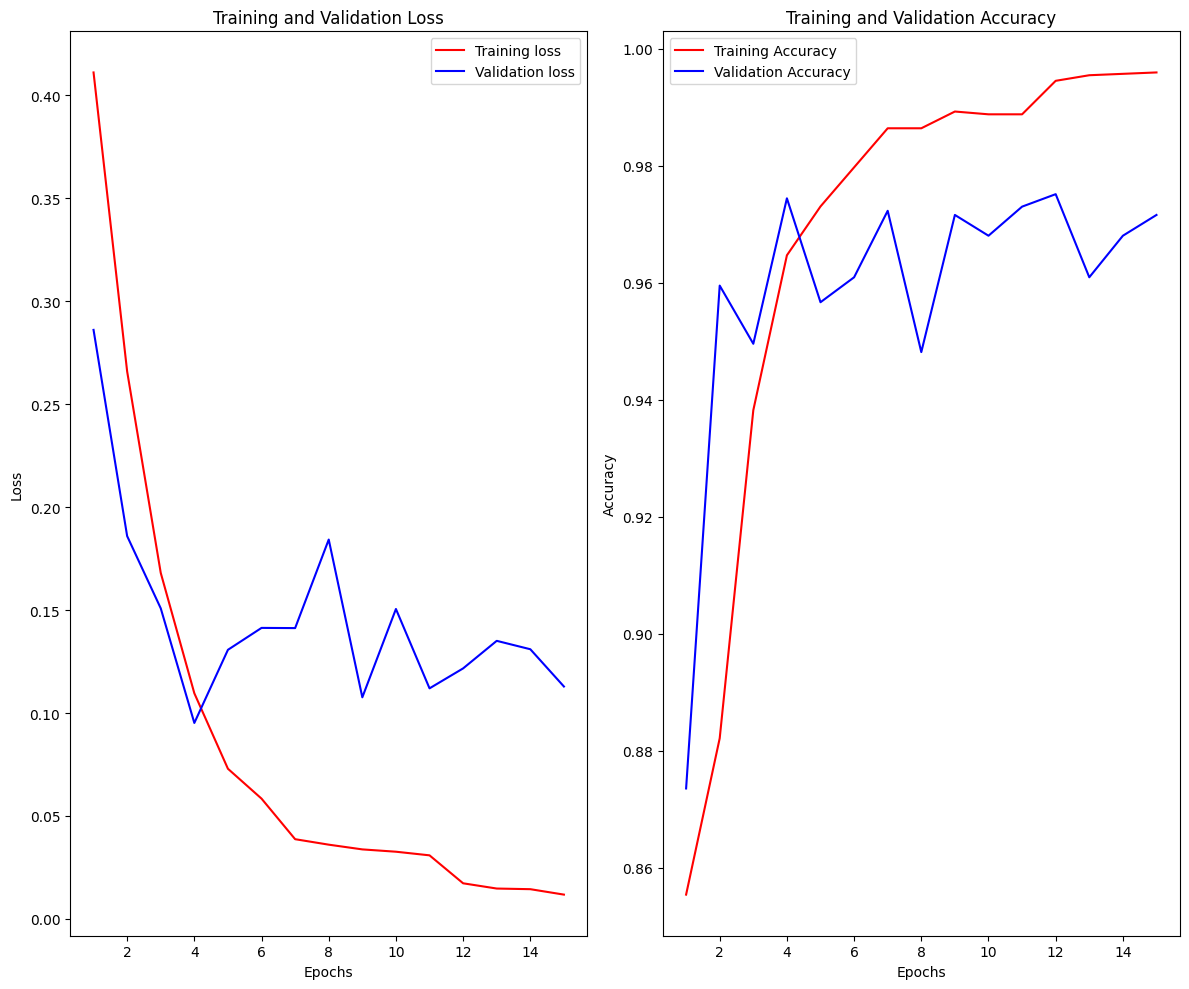

In [57]:
epochs = range(1, EPOCH_NUMBER + 1)

plt.figure(figsize=(12,10))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'r', label='Training loss')
plt.plot(epochs, valid_losses, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'r', label='Training Accuracy')
plt.plot(epochs, valid_accuracies, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [58]:
import numpy as np
from tqdm import tqdm

def get_predictions_and_labels(net, data_iter, loss_fn):
    y_true = []
    y_pred = []
    
    net.eval()
    
    with torch.no_grad():
        for data in tqdm(data_iter, desc="Validation", unit="batch"):
            input_data, input_lengths = data.text
            preds = net(input_data, input_lengths).squeeze()
            loss = loss_fn(preds, data.type)
            
            y_true.extend(data.type.cpu().numpy())
            y_pred.extend(torch.round(preds).cpu().numpy())
    
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    return y_true, y_pred

y_true, y_pred = get_predictions_and_labels(model, validation_iterator, criterion)



Validation: 100%|██████████| 88/88 [00:00<00:00, 519.45batch/s]


# Confusion Matrix

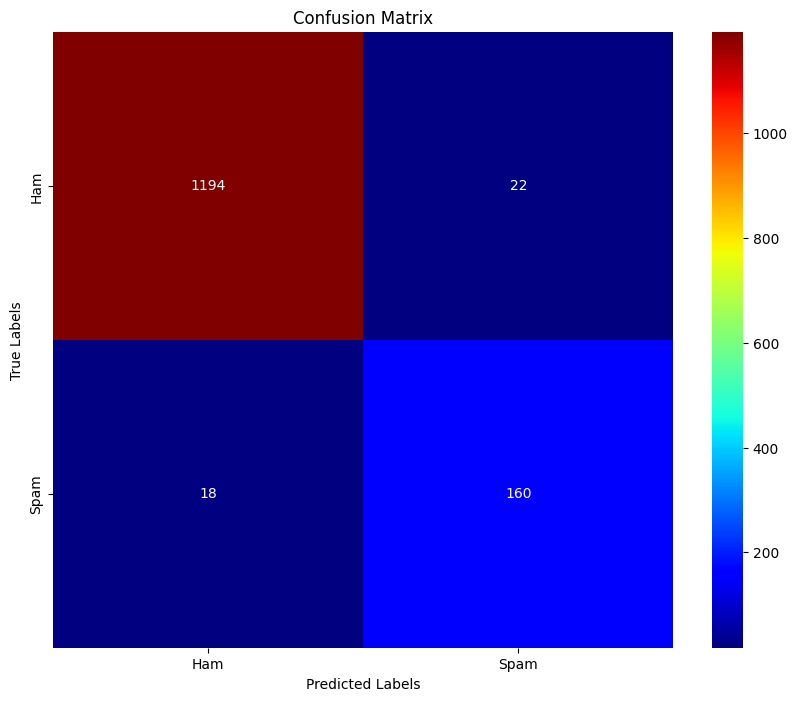

In [59]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
label_name=["Ham","Spam"]
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", cmap="jet", xticklabels=label_name, yticklabels=label_name)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


# Classification Report

In [60]:
print(classification_report(y_true,y_pred,target_names=label_name))

              precision    recall  f1-score   support

         Ham       0.99      0.98      0.98      1216
        Spam       0.88      0.90      0.89       178

    accuracy                           0.97      1394
   macro avg       0.93      0.94      0.94      1394
weighted avg       0.97      0.97      0.97      1394



# Accuracy Score

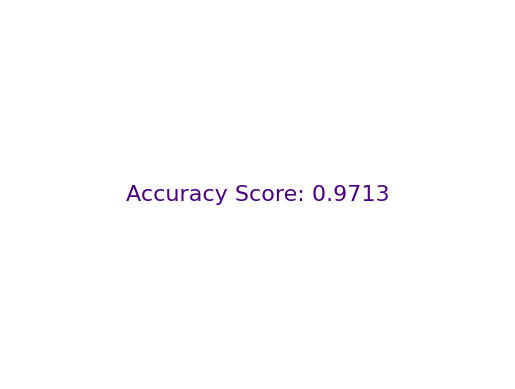

In [61]:
accuracy = accuracy_score(y_true, y_pred)
plt.plot([])
plt.text(0, 0, f'Accuracy Score: {accuracy:.4f}', fontsize=16, ha='center', va='center', color="indigo")
plt.axis('off')
plt.xlim(-1, 1)
plt.ylim(-1, 1)

plt.show()

# Roc Auc Score

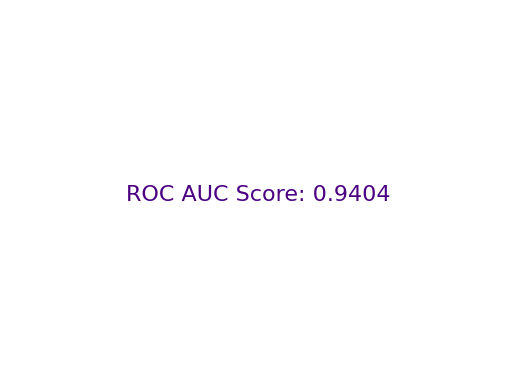

In [62]:
roc_auc = roc_auc_score(y_true, y_pred)

plt.plot([])
plt.text(0, 0, f'ROC AUC Score: {roc_auc:.4f}', fontsize=16, ha='center', va='center', color="indigo")
plt.axis('off')
plt.xlim(-1, 1)
plt.ylim(-1, 1)

plt.show()

# Log Loss

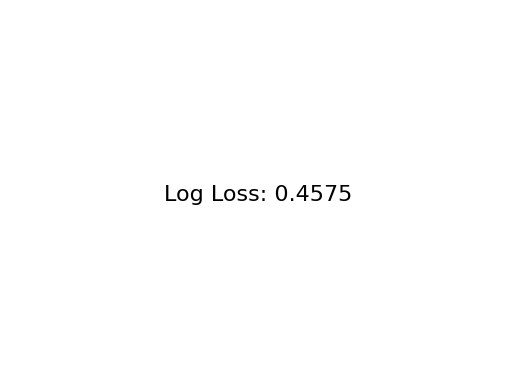

In [63]:
classes = [0, 1]

logarithm_loss = log_loss(y_true, y_pred, labels=classes)

plt.plot([])
plt.text(0, 0, f'Log Loss: {logarithm_loss:.4f}', fontsize=16, ha='center', va='center', color="black")
plt.axis('off')

plt.xlim(-1, 1)
plt.ylim(-1, 1)

plt.show()

# Kappa Score

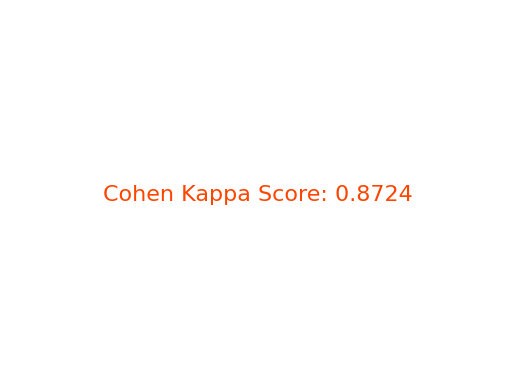

In [64]:
kappa = cohen_kappa_score(y_true,y_pred)
plt.plot([])
plt.text(0,0, f'Cohen Kappa Score: {kappa:.4f}', fontsize=16, ha='center', va='center',color="orangered")
plt.axis('off')

# Set the x-axis limits
plt.xlim(-1, 1)
plt.ylim(-1,1)

plt.show()

# matthews_corrcoef

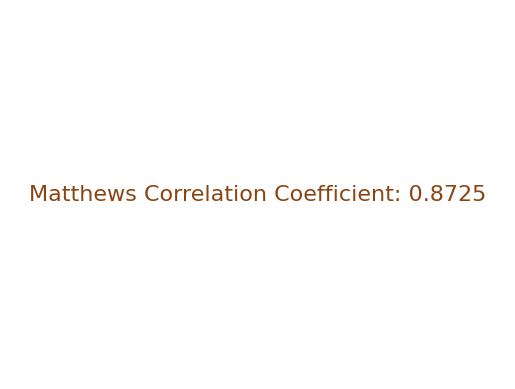

In [65]:
mcc = matthews_corrcoef(y_true,y_pred)

# Create a plot and display the MCC value as text
plt.plot([])
plt.text(0,0, f'Matthews Correlation Coefficient: {mcc:.4f}', fontsize=16, ha='center', va='center',color="saddlebrown")
plt.axis('off')

# Set the x-axis limits
plt.xlim(-1, 1)
plt.ylim(-1,1)

plt.show()

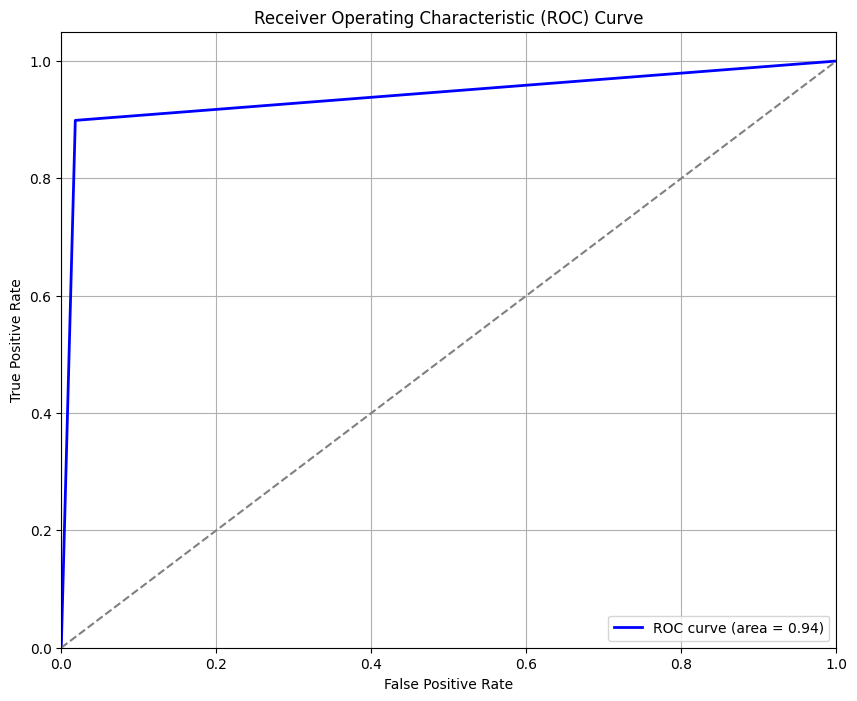

In [66]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(10,8))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Compute Precision-Recall curve

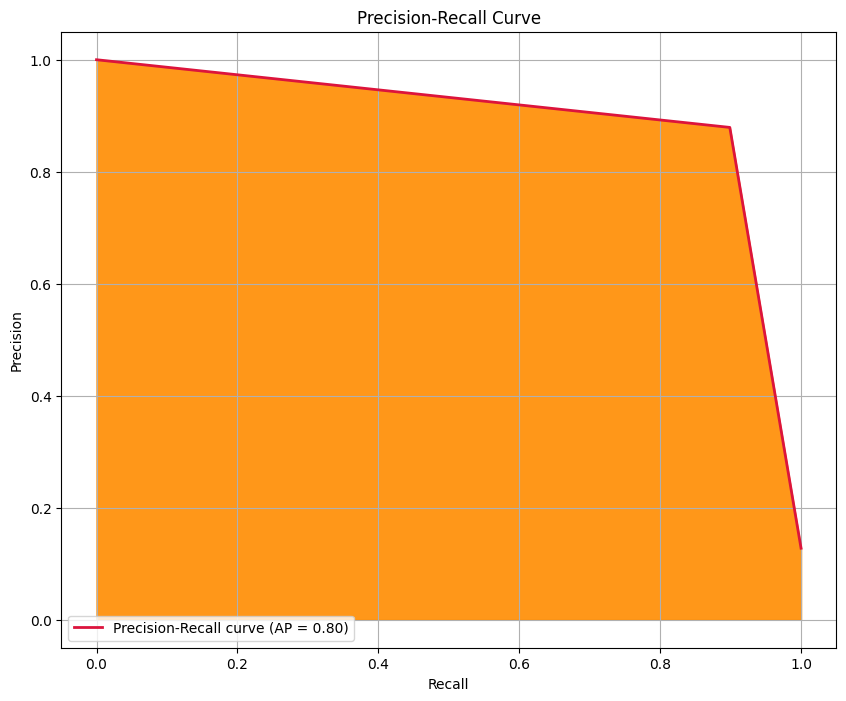

In [67]:
from sklearn.metrics import precision_recall_curve, average_precision_score
precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
average_precision = average_precision_score(y_true, y_pred)

plt.figure(figsize=(10,8))
plt.plot(recall, precision, color='crimson', lw=2, label=f'Precision-Recall curve (AP = {average_precision:.2f})')
plt.fill_between(recall, precision, color='darkorange', alpha=0.9)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

# Custom Data Prediction

In [68]:
from torchtext.data import Field, Example, Dataset, Iterator


TEXT = Field(
    tokenize=lambda x: x.split(), 
    lower=True,
    include_lengths=True,
    batch_first=True
)
LABEL = Field(sequential=False, use_vocab=False, dtype=torch.float)

custom_data = [
    ("Congratulations! You've won a prize, click here to claim it.", 1),
    ("Happy Birthday! Hope you have a wonderful day", 0),
    ("Congratulations! You've won a $1,000 gift card. Claim your prize now by clicking this link", 1),
    ("Winning an unexpected prize sounds great, in theory. However, being notified of winning a contest you didn't enter is a dead giveaway of a phishing text. If you're unsure whether an offer is authentic, contact the business directly to verify.", 0),
    ("free entry wkly comp win fa cup final tkts st may text fa receive entry question std txt rate c apply", 1)
]

examples = [Example.fromlist([text, label], fields=[('text', TEXT), ('label', LABEL)]) 
           for text, label in custom_data]

custom_dataset = Dataset(examples, fields=[('text', TEXT), ('label', LABEL)])

TEXT.build_vocab(custom_dataset, min_freq=1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def sort_key(ex):
    return len(ex.text)

custom_iterator = Iterator(
    custom_dataset, 
    batch_size=1,
    device=device,
    sort=True,
    sort_key=sort_key,
    sort_within_batch=True
)

def predict_custom_data(model, data_iter):
    model.eval()
    predictions = []
    with torch.no_grad():
        for batch in data_iter:
            text, lengths = batch.text
            
            if lengths.dim() > 1:
                lengths = lengths.squeeze(-1)
            
            lengths = lengths.cpu()
            
            try:
                outputs = model(text, lengths).squeeze(1)
                predictions.append(torch.sigmoid(outputs).cpu().item())
            except RuntimeError as e:
                print(f"Error processing batch. Text shape: {text.shape}, Lengths shape: {lengths.shape}")
                print(f"Lengths values: {lengths}")
                raise e
            
    return predictions

predictions = predict_custom_data(model, custom_iterator)

for (text, _), pred in zip(custom_data, predictions):
    label = "spam" if pred > 0.5 else "ham"
    print(f"Text: {text}")
    print(f"Prediction: {label} (confidence: {pred:.4f})")
    print("#" * 120)


Text: Congratulations! You've won a prize, click here to claim it.
Prediction: spam (confidence: 0.5002)
########################################################################################################################
Text: Happy Birthday! Hope you have a wonderful day
Prediction: spam (confidence: 0.5007)
########################################################################################################################
Text: Congratulations! You've won a $1,000 gift card. Claim your prize now by clicking this link
Prediction: spam (confidence: 0.5011)
########################################################################################################################
Text: Winning an unexpected prize sounds great, in theory. However, being notified of winning a contest you didn't enter is a dead giveaway of a phishing text. If you're unsure whether an offer is authentic, contact the business directly to verify.
Prediction: spam (confidence: 0.5000)
####################